In [49]:
import torch
from deepchopper import  remove_intervals_and_keep_left, smooth_label_region, summary_predict, get_label_region

In [50]:
import deepchopper

In [51]:
from deepchopper.utils import alignment_predict, highlight_target, highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.WARN,
    format=FORMAT,
    handlers=[RichHandler()],
)

**TODO**: 

- [ ] summary chop  or not chop
- [ ] summary chop internal or terminal
- [ ] chop only has one interval
- [ ] summary chop interval size

In [52]:
@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id}\n{self.seq}\n+\n{self.qual}"

def vis_qual_static(predict, start: int | None = None, end: int | None = None, figure_size=(20, 1)):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(figsize=figure_size)  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.show()
    plt.close()


def print_seq(predict,  regions ):
    print(f"id     : {predict.id}")
    print(f"regions: {regions}")
    highlight_targets(predict.seq, regions)

def compare_smooth(predict, smooth_window_size: int):
    regions = predict.prediction_region

    window_size = smooth_window_size
    smooth_regions = predict.smooth_prediction_region(window_size)

    print(f"id      : {predict.id}")
    print(f"original: {regions}")
    print(f"smooth  : {smooth_regions}")
    highlight_targets(predict.seq, regions)
    highlight_targets(predict.seq, smooth_regions)

def chop_intervals(predict, *, smooth: bool, smooth_window_size: int | None) -> list[tuple[int, int]]:
    if smooth:
        if smooth_window_size is None:
            raise ValueError("please provide window size")
        window_size = smooth_window_size
        regions = predict.smooth_prediction_region(window_size)
    else:
        regions = predict.prediction_region
    return regions

def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(self.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)

def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:    
    chop_intervals =  stats.smooth_intervals[predict.id] 

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results

In [53]:
from needletail import parse_fastx_file, NeedletailError, reverse_complement, normalize_seq

def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id]  = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result

In [54]:
import pysam
def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)
    
    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name]  = read 

    return result 

In [7]:
sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [8]:
len(sam_records)

8201131

In [9]:
test_chunks = [Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
               Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1")]       

In [10]:
fq_records = collect_fq_records(Path("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"))

In [58]:
len(fq_records)

9177639

In [12]:
## VCaP
hyena_results = [
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"),
]

In [59]:
max_batches  = 1000
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0],
                                                        -100, 
                                                        max_batches)

In [60]:
len(all_predicts)

32000

In [15]:
stats = deepchopper.py_collect_statistics_for_predicts(
    list(all_predicts.values()),
    smooth_window_size=17,
    min_interval_size=7,
    approved_interval_number=5,
    internal_threshold=0.7,
    ploya_threshold=3,
)
stats

StatResult(total_predicts: 30161,  predicts_with_chop: 28155, smooth_predicts_with_chop: 27696,
                        smooth_internal_predicts: 417, total_truncated: 0, smooth_only_one: 27174,
                        smooth_ploya_only_one: 22228)

In [55]:
print(all_predicts[stats.predicts_with_chop[0]].show_info(stats.smooth_intervals[stats.predicts_with_chop[0]]))

id: ac334eb9-ba47-4845-9a60-600d0968b502
prediction: [476..529]
smooth_intervals: [(476, 529)]
CCAGGCCCGGGTGGTTGCTGCCGAAATGGGCAAGTTCATGAAACCTGGGAAGGTGGTGCTTGTCCTGGCTGGACGCTACT
CCGGACGCAAAGCTGTCATCGTGAAGAACATTGATGATGGCACCTCAGATCGCCCAGCCATGCTCTGGTGGCTGGAATTG
ACCGCTACCCCCGCAAAGTGACAGCTGCCATGGGCAAGAAGAAGATCGCCAAGAGATCAAAGATAAAATCTTTTGTTGAA
AGTGTATAACTACAATTCCTAATGCCCACAAGGTACTCTGTGGATATCCCTCCTGGACAAAACTGTCGTCAATAAGGATG
TTTTCAGAGATCCTGCTCTTAAACGCAAGGCCCGACGCGGAAGGCCAAAGTCAAGTTTGAAGAGAGATACAAGACAGGCA
AGAACAAGTGGTTTTTCCAGAAACTGCGGTTTTAGATGCTTTGTTTTGATCATTAAAAATTATAAAGAAAAAAAAATTCC
CACCCCCATCTACACATCCCAACACCCATTTCATCCAACCTACCTAATC

CCAGGCCCGGGTGGTTGCTGCCGAAATGGGCAAGTTCATGAAACCTGGGAAGGTGGTGCTTGTCCTGGCTGGACGCTACT
CCGGACGCAAAGCTGTCATCGTGAAGAACATTGATGATGGCACCTCAGATCGCCCAGCCATGCTCTGGTGGCTGGAATTG
ACCGCTACCCCCGCAAAGTGACAGCTGCCATGGGCAAGAAGAAGATCGCCAAGAGATCAAAGATAAAATCTTTTGTTGAA
AGTGTATAACTACAATTCCTAATGCCCACAAGGTACTCTGTGGATATCCCTCCTGGACAAAACTGTCGTCAATAAGGATG
TTTTCAGAGATCCTGCTCTTAAACGCAAGGCCCGACGCGGAAGG

In [17]:
for pid, p in all_predicts.items():
    p.qual =  fq_records[p.id].qual

In [18]:
len(stats.smooth_internal_predicts)

417

In [19]:
for p in stats.smooth_internal_predicts:
    pd = all_predicts[p]
    sreg = stats.smooth_intervals.get(p, [])

    if len(sreg) >=2:
        print("\n")
        print(pd.show_info(sreg))



id: 3fee8c00-80c9-4e32-afda-ab0c92d3da7e
prediction: [129..130, 132..138, 139..140, 141..142, 143..152, 157..160, 183..184, 188..194, 371..372, 373..374, 4791..4792, 4794..4853]
smooth_intervals: [(133, 155), (4793, 4853)]
ACTCCATCCTTTCCAACACACCCATCCCAACCACACTACCCTATACACATTTTCCTCAACCTAACCTCCACACCTCTCCC
AACACTCCTCAACCTCTCCTCCATTCCACTCCTCTACATTTAACCTCCCATCATCCCACACTCCTACTCCTCTACTCCTA
CTCCCTACCCACCTAACCAACCTATCATTATACTCCCAACATTCCTACACCCTATCACACACACATTCCCATCTATCACC
CATCTCCTACCCACTTATTCCCAAACTCCACTCCATCCATAATTACACCAACCCAACCCTTTTCTATTCCTCTCCCACTT
ATAACCATCACTTACACTACATCTACTTCATTAACTTACCCAACCCCCCCCAATGCCGGCCCCCATCATTGCCGTGGCCG
GCGGGCACTGGGGCCCCGTGTTTTCAGAGTCATGGAGGCGCTAATTCCTGTCATAAACAAGCTCCAGGACGCCACCTTCA
ACACGGTGGGCGCCGACATCATCCAGCTGCCTCAAATCGTCGTAGTGGGAACGCAGAGCAGCGGAAAGAGCTCAGTGCTA
GAAAGCCTGGTGGGGAGGGACCTGCTTCCCAGAGGTACTGGAATTGTCACCCGGAGACCTCTCATCTGCTGGTCCATGTT
TCACAAGAAGATAAACGGAAAACAACAGGAGAAGAAAATGGGGTAGAAGCAGAAGAATGGGGTAATTTTCTTCACACCAA
AATAAGCTTTACACGGATTTTGATGAAATTCGACAAGAAATTGAAA

In [20]:
p = stats.predicts_with_chop[0]
vis_qual_static(all_predicts[p], stats.smooth_intervals[p][0][0] - 10 , stats.smooth_intervals[p][0][1] + 10)

In [21]:
import seaborn as sns
import numpy as np

def vis_hist_for_num_of_intervals(data, figsize=(10,6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1 
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(data, kde=True, color='#66c2a5', line_kws={'linewidth': 2}, discrete=True)
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    else:
        sns.histplot(data, kde=True, color='#66c2a5', line_kws={'linewidth': 2}, discrete=True, ax=ax)
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

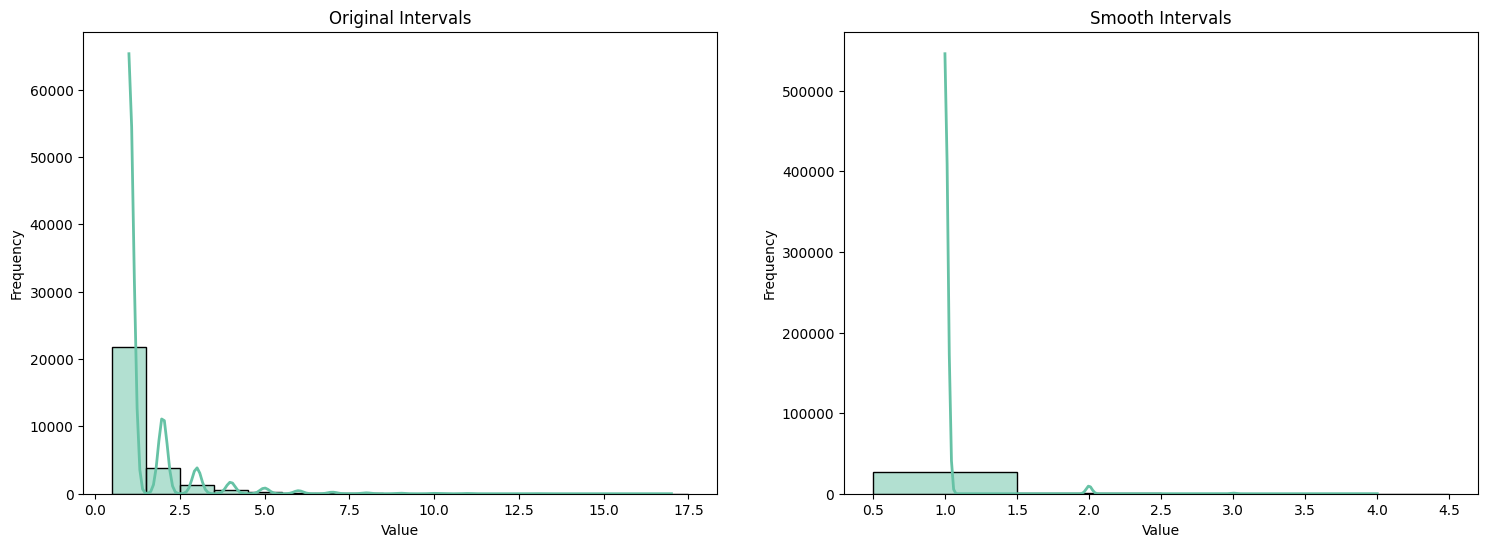

In [22]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [23]:
len(stats.smooth_only_one_with_ploya)

22228

In [24]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()

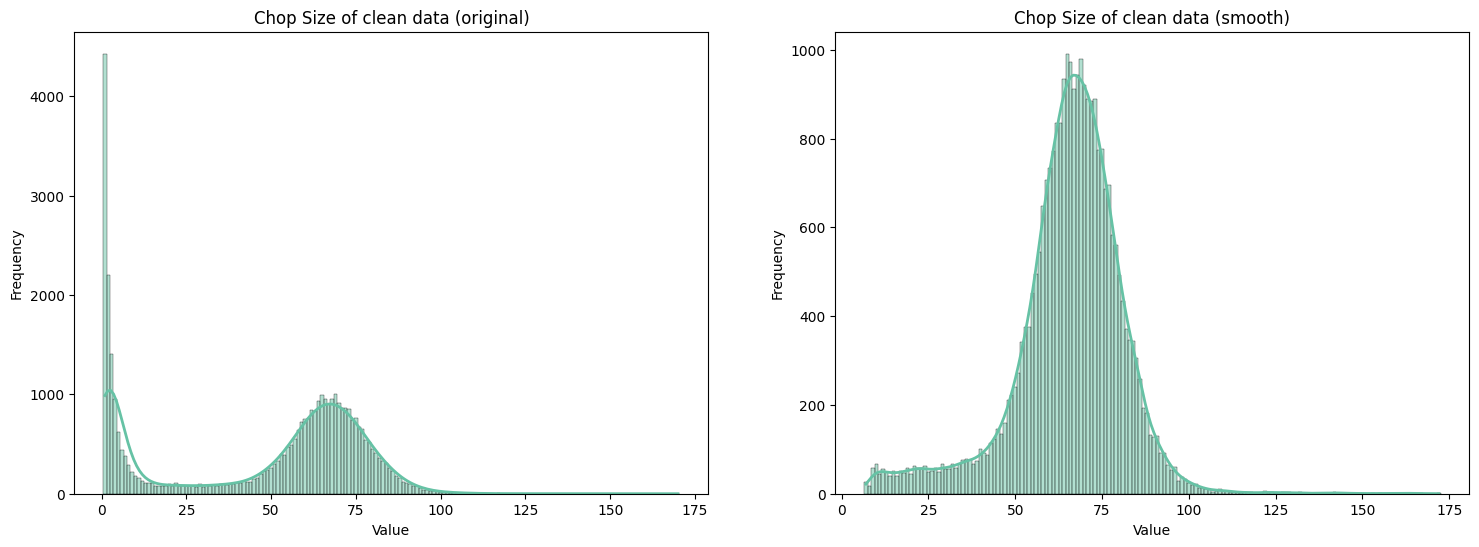

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(plot_oregion_size_data, title="Chop Size of clean data (original)", ax=axs[0])
vis_hist_for_num_of_intervals(plot_sregion_size_data, title="Chop Size of clean data (smooth)", ax=axs[1])

In [26]:
len(stats.smooth_only_one)

27174

In [27]:
len(stats.smooth_predicts_with_chop)

27696

In [28]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id]
        
        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        print(predict.show_info(smooth_regs))

In [29]:
show_examples(set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats)

id: 110600e3-9f28-4241-b251-97da6085885f
prediction: [889..959, 2024..2092, 2093..2094, 2095..2096, 2097..2099]
smooth_intervals: [(889, 959), (2024, 2099)]
GTTCTGCCGTCCTGGGGCGGGGGACGTTTTGGACAGTGGGGTAAACTGAGGCCCGATAGGGGCGCTAGGCACTGCCCGGA
GTCCGGCGCGCACGGATTGAGGCGACCTGATTCCGCCGCATCCTGGCCCGCGCGGCGAGTGTGGTCTCTGGGCTCGGGAC
CTGACTTCTGGCCTGGGGGCCGTGCACCGGCAGCGCAGGATTCAGCCTCTTCCAACTGGCCCTGAGACCACTTTGCGACT
GACCCCGGAGGCTGGAATGCAGTGGTGTGATCTTGGCTCACTGCAGCCTCTACCACCTGGGCTCAAGCAATCTTCCCACC
TCGGCCTCCCAAGTAGCTGGAACTACAGGTGGCCCCAAATCCAAGCAATCCTTATAAGAGAGAGACAGAGGGAGATTTGA
GAGACAGAAGAGGAGGAGGTGATCTGATTACAGAGGCGGAGACGGGTAATGCCCATGCGCCCGAGTTCCCCGGCAGCCAC
TGGAAGCTGGAGAGGTGAGGAGTCGCCCAGGAGGCCCTGAGGGAGCTAGATCAAGTTGCGGCCTCCAGAACTCCAGAGAG
AATGAATGTCTGCTGTTCTCAGCACCCCTCCGTGGTCCTCTGTCACGGCAGCCGCGGGACCCTCACGCGCTGTCTGGGCC
GTCCCTTCCAGCGTGTCGGGCGTTGTGTCCAGCACTGGGACCGCCCTCAGGCGTGACTTGAGCCCTGTTCCAGCCTCTGC
GCGGGGTTGCCCAGACGCCCCTCCAGGGCGTGATGCCACTGCCCCTGGTGGCCGCGGCTGCCCAGACGCCTCTCCTCGCA
GACCCAGCACCGCCAGCACTTGGGAACCAGCTC

In [56]:
import re 
from textwrap import wrap 
from collections import defaultdict 
import gget 


def wrap_str(ostr, width):
    return "\n".join(wrap(ostr, width))


def show_sam_record(predict, stats, sam_records):
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    seq_len = len(predict.seq)
    txt_width = 120

    print(f"\nread id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]

    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0] : interval[1]]
        average_qual = sum(quals) / len(quals)
        print(f"smooth interval : {interval} len: {interval[1] - interval[0]}     {average_qual=}")

    highlight_targets(predict.seq, smooth_intervals)

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print(f"the read is not map")
        return

    if len(smooth_intervals) == 1:
        blat_df = gget.blat(predict.seq[interval[0] : interval[1]])
        if blat_df is not None:
            print(f"blat result:\n {blat_df.to_string()}\n")

    print(f"{predict_read.reference_id=} {predict_read.mapping_quality=}")
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)
    ls_len = int(left_mat.group(1)) if left_mat else 0
    rs_len = int(right_mat.group(1)) if right_mat else 0

    print(f"ls: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[-rs_len:], txt_width)}")

    if predict_read.has_tag("SA"):
        print(f"has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}\t{l_s_len=}\t{r_s_len=}"

            print(f"chimeric : {tgt_key}")


def check_overlap(
    interval1: tuple[int, int], interval2: tuple[int, int], overlap_threshold: float
) -> bool:
    start1, end1 = interval1
    start2, end2 = interval2

    length1 = end1 - start1 
    length2 = end2 - start2

    # Calculate the maximum start point and minimum end point
    max_start = max(start1, start2)
    min_end = min(end1, end2)

    # union 
    min_start = min(start1, start2) 
    max_end = max(end1, end2) 
    
    # Calculate the overlap length
    overlap = max(0, min_end - max_start)

    divide = max(length1, length2)
    
    ratio = overlap / divide

    # Check if the overlap meets or exceeds the threshold
    print(f"compare {interval1}({length1}) {interval2}({length2}) {ratio=}")
    return ratio >= overlap_threshold


def verify_result_with_sam_records(
    predict, stats, sam_records, interval_threshold: float = 0.7, overlap_threshold: float = 0.7
):
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print(f"the read is not map")
        return

    seq_len = len(predict.seq)

    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)
    ls_len = int(left_mat.group(1)) if left_mat else 0
    rs_len = int(right_mat.group(1)) if right_mat else 0

    intervals = stats.smooth_intervals[predict.id]

    # highlight_targets(predict.seq, intervals)
    print("\n")
    print(predict.show_info(intervals))

    txt_width = 120
    print(f"{predict_read.reference_id=} {predict_read.mapping_quality=}")
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}")

    if predict_read.has_tag("SA"):
        print(f"has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}\t{l_s_len=}\t{r_s_len=}"

            print(f"chimeric : {tgt_key}")

    # define results
    overlap_results = defaultdict(list)

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        quals = predict.qual_array()[start:end]
        average_qual = sum(quals) / len(quals)

        if end / seq_len > interval_threshold:
            # terminal adapter
            blat_df = gget.blat(predict.seq[start:end])
            if blat_df is not None:
                print(f"\nblat_df: {blat_df.to_string()}\n")
            else:
                print("blat_df is None")

            # has overlap
            if check_overlap((seq_len - rs_len, seq_len), (start, end), overlap_threshold):
                overlap_results["terminal_chop_sc"].append(predict.id)
            else:
                overlap_results["terminal_chop_nosc"].append(predict.id)
        else:  # internal adapter
            if ls_len != 0:
                if check_overlap((0, ls_len), (start, end), overlap_threshold):
                    overlap_results["internal_chop_sc"].append(predict.id)
                else:
                    overlap_results["internal_chop_nosc"].append(predict.id)

            if rs_len != 0:
                if check_overlap((seq_len - rs_len, seq_len), (start, end), overlap_threshold):
                    overlap_results["internal_chop_sc"].append(predict.id)
                else:
                    overlap_results["internal_chop_nosc"].append(predict.id)
    else:
        # noise predict
        pass

    return overlap_results

In [57]:
for p in stats.smooth_predicts_with_chop[100:200]:
    pd = all_predicts[p]
    sreg = stats.smooth_intervals.get(p, [])
    # show_sam_record(pd, stats, sam_records)
    overlap_result = verify_result_with_sam_records(pd, stats, sam_records)

        # print("\n")
        # print(pd.show_info(sreg))



id: c33797e1-9a66-43a3-988b-c763be784e02
prediction: [978..979, 1898..1981]
smooth_intervals: [(1898, 1981)]
TCCCGGCAGCCCCTTCCTACCTGCGCACGTGGTGCCGCTGCTGCTGCCCTCCCGCTCGCCCTGAACCCCAGTGCCTGCAG
CCATGGCTCCCGGCCGCCACATTTTTAACCTTCAGCGCCCGTGACAAAACGGCCTTGTTGCAAGAAACCCCGACCAATGG
TCTGCACTGCACCTTCCGGAGGGACTGCAAAAGCTCAAATAAAGCACCTGCAGTCAGAGATGTCCTTGAGTTGACGGGAT
CCCTGAAATGTTGGGGGACGTTGTGAAAAACTCAGCCACTCCTGCAGTCCATGCTAGAATCCTAGCTCATGTAATATTCT
CCAGAAGATAATGCTGACATGGCCAGACTTGATTCAATCTTATAAGAGTTGTTGTCCCCAATATCCCTTTTGTAAAGACA
GTGGCTTCTCCAGGTGTAACTGTTGAGGGGAGGCTGTGGAGCAAATCGACATTGGTGGAGTCGTTACCCTACTGAGCTGC
AGCCAAACACTTACGTTAAAGTTGACAGTGGTGTGTGAACAGAGGACTATGTGGTAACTGTGTCCGGAGATGCAGAGCTC
CGAGAGTAAGGACACCTCCTTGGAGACTAGACGCCAGTTAGCCACTTGAAGGCATTCACTCATACGGCACAATATGATGA
AGCAATTCAGATCCATTCAGGGAAACCGAGTCCAGCTAGGCCGTATCTCCAGATGCCCTTGAGATATGGAATGATCCCAC
CATGGATCCCTGCCCAGCTGTACACACACTGCAGCCCAAGCTTCCCCCATCACAGCTTCTAAATGGAACGCCCCTGATTT
ATCAAACTTGTTGCGATGCTCGACCCGGCCAGCAGCAGGAACTCAAGGGCGCCAGGTATTCCAGCCATCTGCCTCTTTC

[04/19/24 15:27:10] ERROR                                                                          ]8;id=685441;file:///projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/gget/gget_blat.py\gget_blat.py]8;;\:]8;id=624206;file:///projects/b1171/ylk4626/mambaforge/envs/deepchopper/lib/python3.10/site-packages/gget/gget_blat.py#169\169]8;;\
                                         BLAT of seqtype 'DNA' using assembly 'hg38' was                           
                             unsuccesful.                                                                          
                                         Possible causes:                                                          
                                         - Sequence possibly too short (required minimum: 20                       
                             characters).                                                                          
                                         - Assembly possibly invalid. All available species with                   
                             their respective assemblies are listed at                                             
                             https://genome.ucsc.edu/cgi-bin/hgBlat.                                               
                                                                                                                   

blat_df is None
compare (2395, 2397)(2) (2385, 2397)(12) ratio=0.16666666666666666


id: 17a98328-f23a-4461-876c-1100c76f9ee8
prediction: [470..523]
smooth_intervals: [(470, 523)]
GGGTCGCCGTCGCGGAGAGCCGCCAACGTACCTTGCGCATCTGCAATCGGATAGTCGTGCGGAACTGCTCCAGTTTCCTG
ATCAAGAGGAGCAAGCAGACACAGCACTGAGCCCAATATCTTGAAGGCCCAATTCCTCCGCAATCAACGGACTGATTCAC
CGCAAGAGTTGTGGGCGTGGAGCCAGCAGCCGACGGCAAAGGTGTCGTGGTGGTCATTAAGCGGAGATCCAGCCGGGAAG
CCTGCCACCCTTATGTGCGGACCACCATCAACAAGAATGCTCGCGCCACGCTCAGCAGCATCAGACACATGATCCGCAAG
ATCAAGTACCGCCCCGACCTGCGCGCAGCCATGCAGGGCCAGCGCCATCCTGCGCGGCCAGAAGCCAGCAGTCGGTGAAG
CGGACCCGCCCAACCAAGAATCCTGAGCCCCCTGCCCCCAGAGCAATAAAGTCAGCTGGCTTCTCAAAAATCCCCTCTCC
CACCATCTATCTCCATCACATCATCCATCCCACATCCCTCTCC

GGGTCGCCGTCGCGGAGAGCCGCCAACGTACCTTGCGCATCTGCAATCGGATAGTCGTGCGGAACTGCTCCAGTTTCCTG
ATCAAGAGGAGCAAGCAGACACAGCACTGAGCCCAATATCTTGAAGGCCCAATTCCTCCGCAATCAACGGACTGATTCAC
CGCAAGAGTTGTGGGCGTGGAGCCAGCAGCCGACGGCAAAGGTGTCGTGGTGGTCATTAAGCGGAGATCCAGCCGGGAAG
CCTGCCACCCTTATGTGCGGACCACCATCAACAAGAATGCTCGCGC

In [43]:
overlap_result

defaultdict(list,
            {'terminal_chop_nosc': ['c8ca41b2-59f9-4d3c-8c6a-6bcadc1a4891']})